In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import matplotlib
matplotlib.rcParams['figure.figsize'] = [10,7]
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams ['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['font.size'] = 19
matplotlib.rcParams['font.family']= 'DejaVu Serif'
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams['errorbar.capsize'] = 3
matplotlib.rcParams['figure.facecolor'] = (1,1,1)

In [2]:
from kdfit.calculate import System, Calculation
from kdfit.analysis import Analysis
from kdfit.data import DataLoader

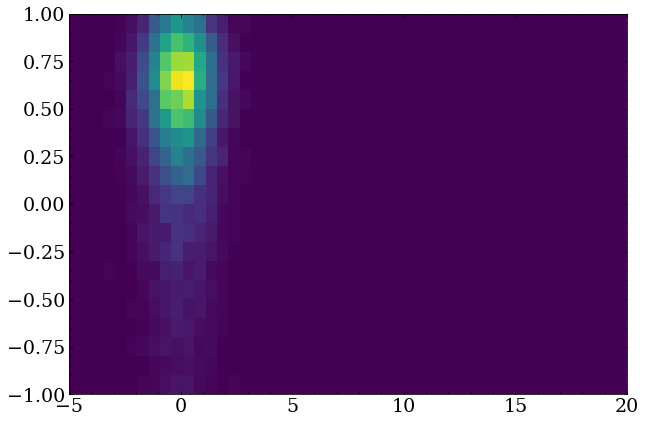

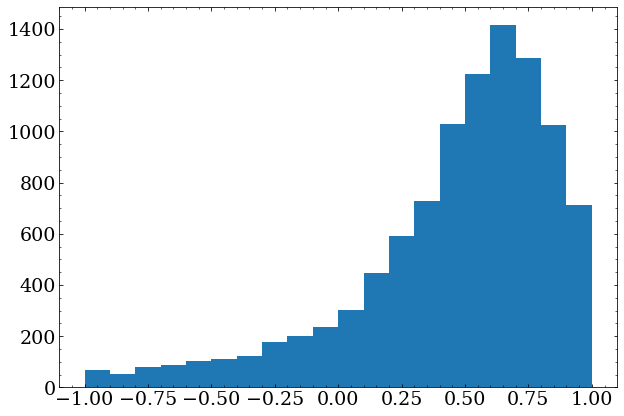

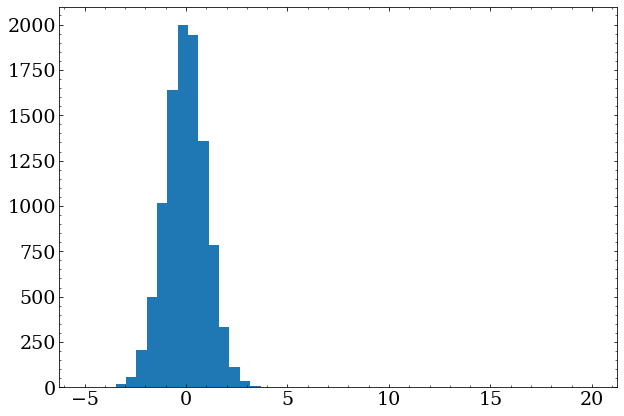

In [3]:
time = np.random.normal(0,1.0,10000)
angle = np.random.standard_cauchy(5*len(time))/3+0.65
angle = angle[np.logical_and(angle>-1,angle<1)]
angle = angle[:len(time)]
plt.hist2d(time,angle,bins=(np.linspace(-5,20,50),np.linspace(-1,1,21)))
plt.show()
plt.close()
plt.hist(angle,bins=np.linspace(-1,1,21))
plt.show()
plt.close()
plt.hist(time,bins=np.linspace(-5,20,50))
plt.show()
plt.close()

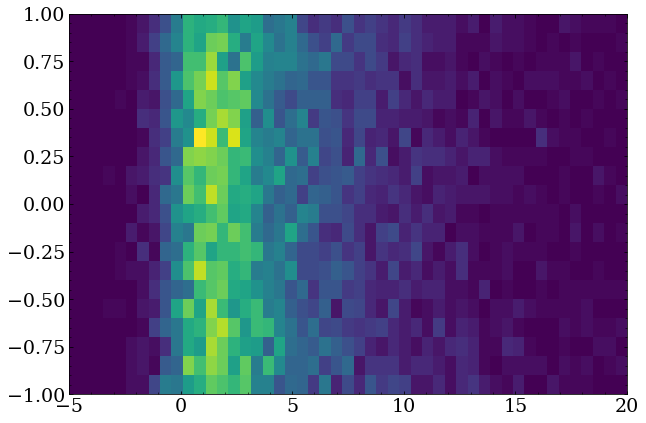

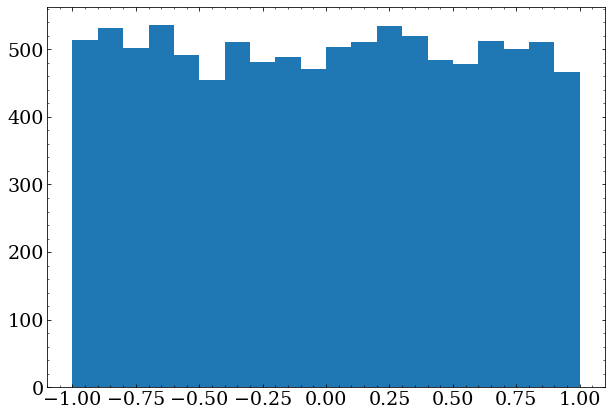

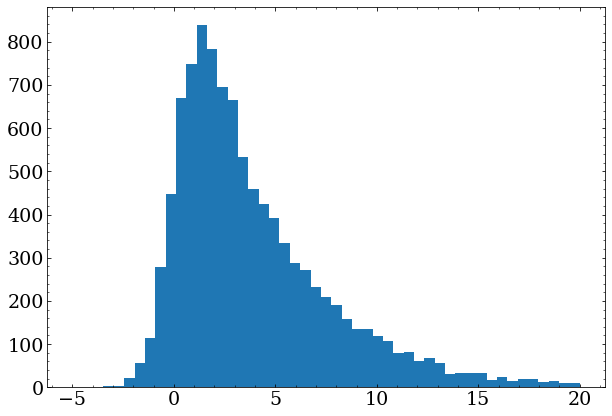

In [4]:
time = np.random.exponential(4.0,10000)
time += np.random.normal(0,1,len(time))
angle = np.random.random(len(time))*2-1
plt.hist2d(time,angle,bins=(np.linspace(-5,20,50),np.linspace(-1,1,21)))
plt.show()
plt.close()
plt.hist(angle,bins=np.linspace(-1,1,21))
plt.show()
plt.close()
plt.hist(time,bins=np.linspace(-5,20,50))
plt.show()
plt.close()

In [5]:
import scipy.optimize as opt

def simulate(position,direction,scint_photons,cher_photons,radius=10e3):
    time_scint = np.random.exponential(4.0,scint_photons)
    time_scint += np.random.normal(0,1,scint_photons)
    angle_scint = np.random.random(scint_photons)*2-1
    
    time_cher = np.random.normal(0,1.0,cher_photons)
    angle_cher = np.random.standard_cauchy(5*cher_photons)/3+0.65
    angle_cher = angle_cher[np.logical_and(angle_cher>-1,angle_cher<1)]
    angle_cher = angle_cher[:cher_photons]
    
    time = np.concatenate([time_scint,time_cher])
    cosalpha = np.concatenate([angle_scint,angle_cher])   
    sinalpha = np.sqrt(1-np.square(cosalpha))
    
    phi = np.random.random(scint_photons+cher_photons)*2*np.pi
    a_perp = np.cross(direction,[0,0,1])
    b_perp = np.cross(direction,a_perp)
    phi_dir = np.outer(np.sin(phi),a_perp) + np.outer(np.cos(phi),b_perp)
    photon_dir = np.outer(cosalpha,direction)+(sinalpha*phi_dir.T).T
    dist = [opt.brentq(
            lambda x: np.sum(np.square(position+x*d))-radius*radius,
            0,2.1*radius) for d in photon_dir]
    xyzt = np.asarray([np.append(position+x*d,t+x/300) for x,d,t in zip(dist,photon_dir,time)])
    return xyzt[np.argsort(xyzt[:,3])]

In [6]:
class HitTimeResidualsCosAlpha(Calculation):
    def __init__(self,name,event_param,x_param,y_param,z_param,t_param,theta_param,phi_param,speed_of_light=300):
        super().__init__(name,[event_param,x_param,y_param,z_param,t_param,theta_param,phi_param])
        self.speed_of_light = speed_of_light
        
    def calculate(self,inputs,verbose=False):
        event = np.asarray(inputs[0],dtype=np.float64)
        gxyz = np.asarray(inputs[1:4],dtype=np.float64)
        gt = np.asarray(inputs[4],dtype=np.float64)
        gtheta,gphi = np.asarray(inputs[5:7],dtype=np.float64)
        gdir = [np.cos(gphi)*np.sin(gtheta), np.sin(gphi)*np.sin(gtheta), np.cos(gtheta)]
        P = event[:,:3]-gxyz
        Pnorm = np.sqrt(np.sum(np.square(P),axis=1))
        cosalpha = np.dot((P.T/Pnorm).T,gdir)
        D = np.sqrt(np.sum(np.square(P),axis=1))
        htr = event[:,3]-gt-D/self.speed_of_light
        result = np.asarray([htr,cosalpha]).T
        #a hack, since this is input to Observable
        return lambda: result 

In [7]:
class Cher(DataLoader):
    def __init__(self):
        super().__init__('Cherenkov_gen')
        
    def __call__(self):
        time = np.random.normal(0,1.0,10000)
        angle = np.random.standard_cauchy(5*len(time))/3+0.65
        angle = angle[np.logical_and(angle>-1,angle<1)]
        angle = angle[:len(time)]
        return np.asarray([time,angle]).T
        
class Scint(DataLoader):
    def __init__(self):
        super().__init__('Scintillation_gen')
        
    def __call__(self):
        time = np.random.exponential(4.0,10000)
        time += np.random.normal(0,1,len(time))
        angle = np.random.random(len(time))*2-1
        return np.asarray([time,angle]).T

In [8]:
a = Analysis()
obs = a.add_observables('Recon2D')
obs.add_dimension('TimeResidual',-5,20)
obs.add_dimension('CosAlpha',-1,1)
scint_sig = obs.add_signal('Scint',value=50.0,reflect_axes=[False,True])
cher_sig = obs.add_signal('Cher',value=50.0,reflect_axes=[False,False])
event_param = a.add_parameter("EVT",value=None,fixed=True)
x_param = a.add_parameter("X",value=0,fixed=False)
y_param = a.add_parameter("Y",value=0,fixed=False)
z_param = a.add_parameter("Z",value=0,fixed=False)
t_param = a.add_parameter("T",value=0,fixed=False)
theta_param = a.add_parameter("Theta",value=0,fixed=False)
phi_param = a.add_parameter("Phi",value=0,fixed=False)
htrca = HitTimeResidualsCosAlpha("HTRCA",event_param,x_param,y_param,z_param,t_param,theta_param,phi_param)

In [9]:
mc_files = dict(Recon2D=dict(Scint=Scint(),Cher=Cher()))
a.load_mc(mc_files)

In [10]:
a.load_data(dict(Recon2D=htrca))

In [11]:
a.create_likelihood(verbose=True)

Ouput Values: [Total_Likelihood]
Recon2D_UnbinnedLikelihood => Total_Likelihood
Scint_nev => Recon2D_UnbinnedLikelihood
Cher_nev => Recon2D_UnbinnedLikelihood
Scint => Recon2D_UnbinnedLikelihood
Cher => Recon2D_UnbinnedLikelihood
Recon2D => Recon2D_UnbinnedLikelihood
Scint_mc => Scint
TimeResidual_scale => Scint
TimeResidual_shift => Scint
TimeResidual_resolution => Scint
CosAlpha_scale => Scint
CosAlpha_shift => Scint
CosAlpha_resolution => Scint
Cher_mc => Cher
TimeResidual_scale => Cher
TimeResidual_shift => Cher
TimeResidual_resolution => Cher
CosAlpha_scale => Cher
CosAlpha_shift => Cher
CosAlpha_resolution => Cher
Recon2D_data => Recon2D
Scintillation_gen => Scint_mc
Cherenkov_gen => Cher_mc
HTRCA => Recon2D_data
EVT => HTRCA
X => HTRCA
Y => HTRCA
Z => HTRCA
T => HTRCA
Theta => HTRCA
Phi => HTRCA
Floated Parameters: [Scint_nev, Cher_nev, X, Y, Z, T, Theta, Phi]
Fixed Parameters: [TimeResidual_scale, TimeResidual_shift, TimeResidual_resolution, CosAlpha_scale, CosAlpha_shift, CosA

(array([ 4.,  3.,  4.,  7., 13.,  9., 13., 22., 13., 24., 19., 24., 13.,
        16.,  8.,  6.,  2.,  4.,  4.,  6.,  2.,  2.,  4.,  8.,  3.,  2.,
         2.,  0.,  3.,  0.,  2.,  3.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([29.51905362, 30.12373547, 30.72841731, 31.33309916, 31.93778101,
        32.54246285, 33.1471447 , 33.75182655, 34.3565084 , 34.96119024,
        35.56587209, 36.17055394, 36.77523578, 37.37991763, 37.98459948,
        38.58928132, 39.19396317, 39.79864502, 40.40332687, 41.00800871,
        41.61269056, 42.21737241, 42.82205425, 43.4267361 , 44.03141795,
        44.63609979, 45.24078164, 45.84546349, 46.45014534, 47.05482718,
        47.65950903, 48.26419088, 48.86887272, 49.47355457, 50.07823642,
        50.68291827, 51.28760011, 51.89228196, 52.49696381, 53.10164565,
        53.7063275 , 54.31100935, 54.91569119, 55.52037304, 56.12505489,
        56.72973674, 57.33441858, 57.93910043, 58.54378228,

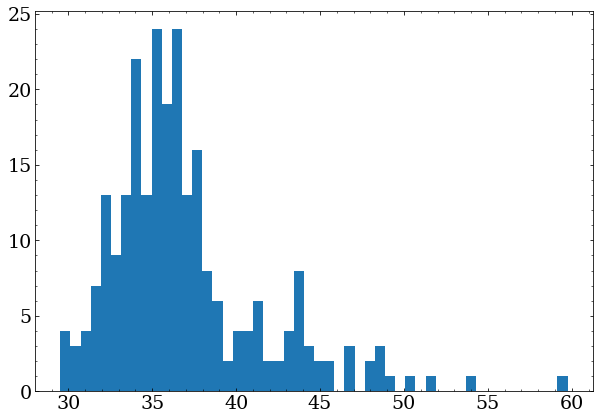

In [12]:
scint_sig.nev_param.value = 200
cher_sig.nev_param.value = 50
x_param.value = 1000
x_param.fixed = True
y_param.value = 0
y_param.fixed = True
z_param.value = 0
z_param.fixed = True
a.update_likelihood()
event_param.value = simulate([x_param.value,y_param.value,z_param.value],
                             [-1,0,0],
                             scint_sig.nev_param.value,cher_sig.nev_param.value)
plt.hist(event_param.value[:,3],50)

In [13]:
a() #calculate the likelihood at central values to load data & mc 

-284.4040673145148

rough int 1.0247724749494536


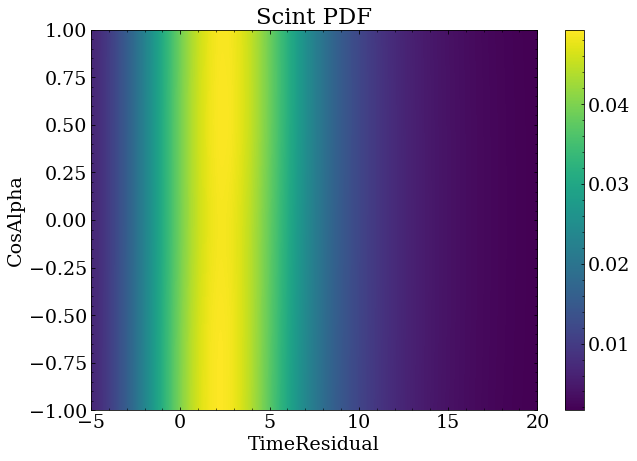

rough int 1.0127033525127265


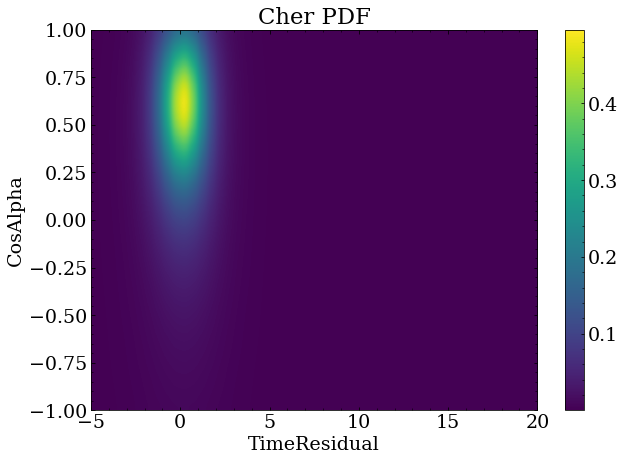

In [14]:
for s in obs.signals.values():
    Xv,Yv = np.linspace(obs.lows[0],obs.highs[0],50),np.linspace(obs.lows[1],obs.highs[1],50)
    X,Y = np.meshgrid(Xv,Yv)
    x_kj = list(zip(X.flatten(),Y.flatten()))
    Z = s.eval_pdf_multi(x_kj)
    print('rough int',np.sum(Z)*(Xv[1]-Xv[0])*(Yv[1]-Yv[0]))
    Z = np.asarray(Z).reshape(X.shape)
    plt.imshow(Z,extent=[np.min(Xv),np.max(Xv),np.max(Yv),np.min(Yv)],aspect='auto',interpolation='gaussian')
    plt.colorbar()
    #plt.scatter(*(s.t_ij.T if np == cp else s.t_ij.T.get()),c='r',marker='x')
    plt.xlim(obs.lows[0],obs.highs[0])
    plt.ylim(obs.lows[1],obs.highs[1])
    plt.xlabel(obs.dimensions[0])
    plt.ylabel(obs.dimensions[1])
    plt.title('%s PDF'%s.name)
    plt.show()
    plt.close()

rough int 1.022358650462108


Text(0, 0.5, 'CosAlpha')

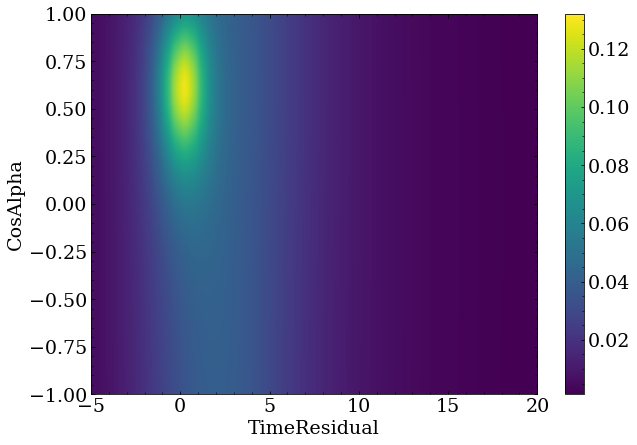

In [15]:
Xv,Yv = np.linspace(obs.lows[0],obs.highs[0],50),np.linspace(obs.lows[1],obs.highs[1],50)
X,Y = np.meshgrid(Xv,Yv)
x_kj = list(zip(X.flatten(),Y.flatten()))
Z = obs.eval_pdf_multi(x_kj)
print('rough int',np.sum(Z)*(Xv[1]-Xv[0])*(Yv[1]-Yv[0]))
Z = np.asarray(Z).reshape(X.shape)
plt.imshow(Z,extent=[np.min(Xv),np.max(Xv),np.max(Yv),np.min(Yv)],aspect='auto',interpolation='gaussian')
plt.colorbar()    
#plt.scatter(*obs.x_ij.T,c='r',marker='x')
plt.xlim(obs.lows[0],obs.highs[0])
plt.ylim(obs.lows[1],obs.highs[1])
plt.xlabel(obs.dimensions[0])
plt.ylabel(obs.dimensions[1])

In [16]:
margs = dict(method='Nelder-Mead',options=dict(fatol=0.001,xatol=0.1))

In [17]:
%prun m = a.minimize(**margs)
print(m)

  final_simplex: (array([[168.39795659,  81.59153323,   0.6913576 ,   1.36353271,
          2.99397749],
       [168.408537  ,  81.53740978,   0.6907761 ,   1.36330619,
          2.99364398],
       [168.3420552 ,  81.61930865,   0.69059952,   1.36342368,
          2.99306146],
       [168.4203012 ,  81.56612492,   0.69077592,   1.36347774,
          2.9925599 ],
       [168.37750805,  81.61238317,   0.69011477,   1.36265794,
          2.99304158],
       [168.31392891,  81.64792281,   0.69229552,   1.3633248 ,
          2.99398296]]), array([-308.28906132, -308.28905999, -308.28905877, -308.28904432,
       -308.28904206, -308.28903033]))
           fun: -308.2890613204163
       message: 'Optimization terminated successfully.'
          nfev: 277
           nit: 169
        params: {Scint_nev: 168.39795659269618, Cher_nev: 81.59153322572449, T: 0.6913575958272662, Theta: 1.3635327130691781, Phi: 2.9939774897570066}
        status: 0
       success: True
             x: array([168.397

Floated Parameters: [Cher_nev, T, Theta, Phi]
Fixed Parameters: [Scint_nev, TimeResidual_scale, TimeResidual_shift, TimeResidual_resolution, CosAlpha_scale, CosAlpha_shift, CosAlpha_resolution, EVT, X, Y, Z]


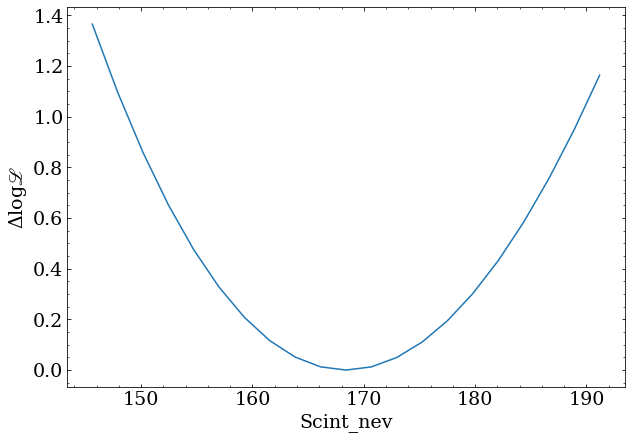

Floated Parameters: [Scint_nev, T, Theta, Phi]
Fixed Parameters: [Cher_nev, TimeResidual_scale, TimeResidual_shift, TimeResidual_resolution, CosAlpha_scale, CosAlpha_shift, CosAlpha_resolution, EVT, X, Y, Z]


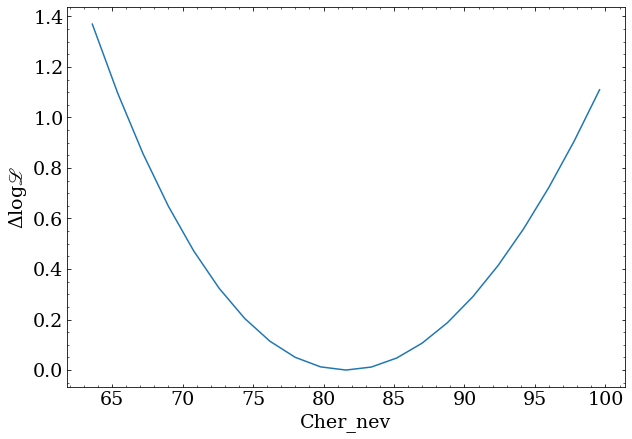

Floated Parameters: [Scint_nev, Cher_nev, Theta, Phi]
Fixed Parameters: [TimeResidual_scale, TimeResidual_shift, TimeResidual_resolution, CosAlpha_scale, CosAlpha_shift, CosAlpha_resolution, EVT, X, Y, Z, T]


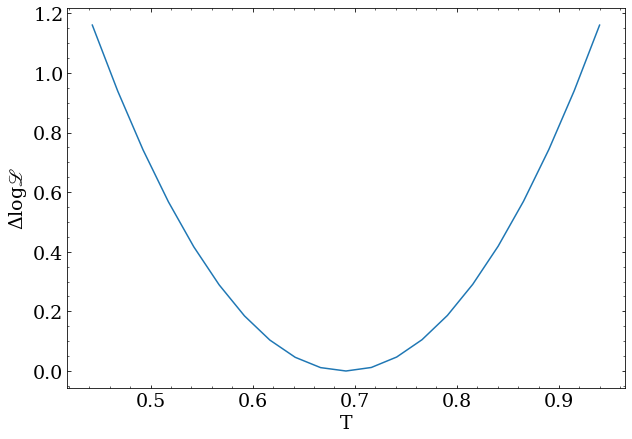

Floated Parameters: [Scint_nev, Cher_nev, T, Phi]
Fixed Parameters: [TimeResidual_scale, TimeResidual_shift, TimeResidual_resolution, CosAlpha_scale, CosAlpha_shift, CosAlpha_resolution, EVT, X, Y, Z, Theta]


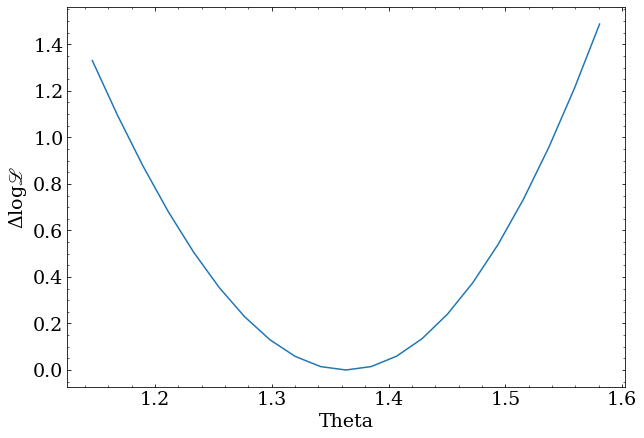

Floated Parameters: [Scint_nev, Cher_nev, T, Theta]
Fixed Parameters: [TimeResidual_scale, TimeResidual_shift, TimeResidual_resolution, CosAlpha_scale, CosAlpha_shift, CosAlpha_resolution, EVT, X, Y, Z, Phi]


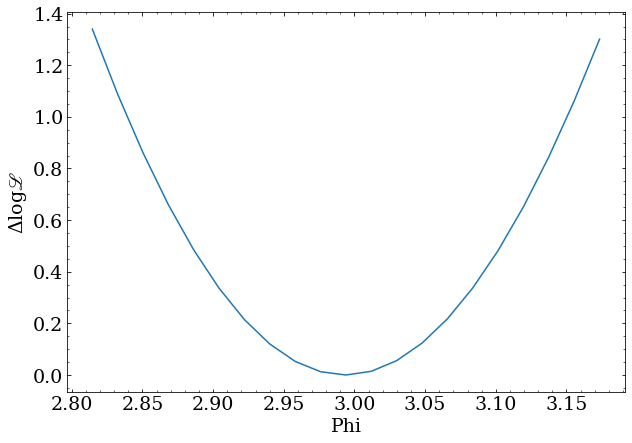

In [18]:
for _p,_v in m.params.items():
    _p.value = _v
    _p.fixed = False
for p,v in m.params.items():
    p.fixed = True
    a.update_likelihood(verbose=True)
    for step in np.logspace(-2,5,100):
        p.value = v*(1-step)
        if a() - m.fun < 1:
            continue
        p.value = v*(1+step)
        if a() - m.fun < 1:
            continue
        break
    X = np.linspace(v*(1-step),v*(1+step),21)
    Y = []
    for x in X:
        p.value = x
        nll = a() - m.fun
        Y.append(nll)
    p.fixed = False
    p.value = v
    plt.plot(X,Y)
    plt.xlabel(p.name)
    plt.ylabel(r'$\Delta$log$\scrL$')
    plt.show()
    plt.close()

In [19]:
%prun a.confidence_intervals(m,method='scan')
print(m)

  final_simplex: (array([[168.39795659,  81.59153323,   0.6913576 ,   1.36353271,
          2.99397749],
       [168.408537  ,  81.53740978,   0.6907761 ,   1.36330619,
          2.99364398],
       [168.3420552 ,  81.61930865,   0.69059952,   1.36342368,
          2.99306146],
       [168.4203012 ,  81.56612492,   0.69077592,   1.36347774,
          2.9925599 ],
       [168.37750805,  81.61238317,   0.69011477,   1.36265794,
          2.99304158],
       [168.31392891,  81.64792281,   0.69229552,   1.3633248 ,
          2.99398296]]), array([-308.28906132, -308.28905999, -308.28905877, -308.28904432,
       -308.28904206, -308.28903033]))
           fun: -308.2890613204163
         lower: {Scint_nev: 14.02031707444604, Cher_nev: 11.11104988888161, T: 0.16131402031323883, Theta: 0.1307647283524589, Phi: 0.10817188588892845}
       message: 'Optimization terminated successfully.'
          nfev: 277
           nit: 169
        params: {Scint_nev: 168.39795659269618, Cher_nev: 81.5915332